In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [13]:
df = pd.read_csv('./clean/cleaned_features_Lasso.csv')
df.columns

Index(['Unnamed: 0', 'time', 'fights_f1', 'win_proportion_f2', 'height_diff',
       'reach_diff', 'outcome'],
      dtype='object')

In [14]:
df.head()

,Unnamed: 0,time,fights_f1,win_proportion_f2,height_diff,reach_diff,outcome
0,0,300,5.0,0.4,-1.0,1.0,0.0
1,1,300,6.0,0.4,-2.0,1.0,1.0
2,2,292,5.0,0.4,-1.0,-1.0,0.0
3,3,300,7.0,0.4,-3.0,2.0,1.0
4,4,300,1.0,0.4,-2.0,0.0,0.0


In [15]:
#We will not know the time at the time of prediction, so dropping it for now

df.drop(['Unnamed: 0','time'], axis=1, inplace=True)

In [16]:
#Creates y and X variables
y= df['outcome'] #Outcome = 1 means figher 1 won, Outcome = 2 means fighter 2 won
X = df.loc[:, df.columns != 'outcome']

X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_orig)
X_test = scaler.transform(X_test_orig)

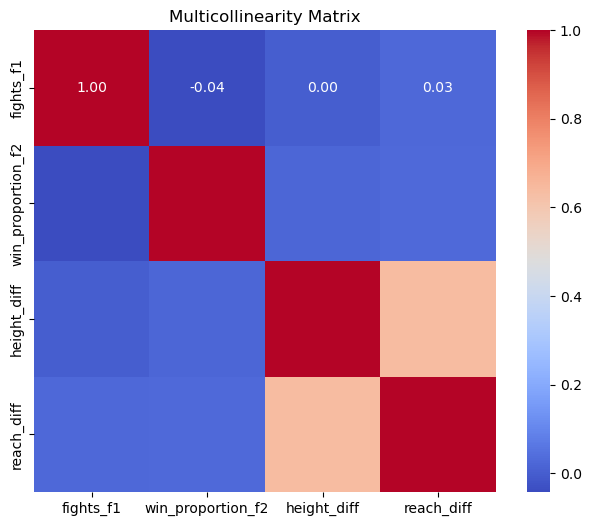

In [17]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Multicollinearity Matrix')
plt.show()

In [18]:
corr_matrix

,fights_f1,win_proportion_f2,height_diff,reach_diff
fights_f1,1.000000,-0.042247,0.001321,0.025157
win_proportion_f2,-0.042247,1.000000,0.022820,0.028486
height_diff,0.001321,0.022820,1.000000,0.637836
reach_diff,0.025157,0.028486,0.637836,1.000000


In [19]:
import statsmodels.api as sm

#Log regression similar to glm in R
# Add a constant term for the intercept
b = sm.add_constant(X_train_orig)
log_reg = sm.Logit(y_train, X_train_orig).fit(maxiter=2000) 

# printing the summary table 
print(log_reg.summary()) 
p_values=log_reg.pvalues
# Select significant features with p-values less than 0.05
significant_features = X_train_orig.columns[p_values < 0.05]

print("Significant features:")
print(significant_features)

Optimization terminated successfully.
         Current function value: 0.615967
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 3483
Model:                          Logit   Df Residuals:                     3479
Method:                           MLE   Df Model:                            3
Date:                Sat, 20 Apr 2024   Pseudo R-squ.:                 0.09660
Time:                        05:04:25   Log-Likelihood:                -2145.4
converged:                       True   LL-Null:                       -2374.8
Covariance Type:            nonrobust   LLR p-value:                 4.023e-99
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
fights_f1            -0.0473      0.006     -7.587      0.000      -0.060      -0.035
win_prop

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from scipy.stats import randint

def find_best_model(X_train, y_train, models):
    best_models = {}
    
    for model_name, model in models.items():
        print(f"Searching for best {model_name}...")
        
        # Define parameter grid for each model
        param_dist = {}
        if model_name == 'Logistic Regression':
            param_dist = {
            }
        elif model_name == 'SVM':
            param_dist = {
                'C': np.logspace(-3, 3, 7),
                'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
            }
        elif model_name == 'Random Forest Classifier':
            param_dist = {
                "n_estimators": randint(100, 1000),
                "max_features": ['auto', 'sqrt', 'log2'],
                "max_depth": [None] + list(range(5, 30)),
                "min_samples_split": randint(2, 20),
                "min_samples_leaf": randint(1, 20),
                "bootstrap": [True, False]
            }
        elif model_name == 'MLP Classifier':
            param_dist = {
                'hidden_layer_sizes': [(100,), (50, 50), (100, 50, 100)],
                'activation': ['relu', 'tanh', 'logistic'],
                'alpha': [0.0001, 0.001, 0.01],
                'learning_rate': ['constant', 'invscaling', 'adaptive']
            }
        
        # Create RandomizedSearchCV object
        random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                           n_iter=10, cv=5, scoring='accuracy',
                                           verbose=1, random_state=42, n_jobs=-1)
        
        # Fit RandomizedSearchCV object to the data
        random_search.fit(X_train, y_train)
        
        # Print best parameters and score
        print(f"Best parameters for {model_name}: {random_search.best_params_}")
        print(f"Best accuracy for {model_name}: {random_search.best_score_}\n")
        
        # Save best model
        best_models[model_name] = random_search.best_estimator_

    # Add a hard voting classifier
    voting_classifier = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    voting='hard')
    voting_classifier.fit(X_train, y_train)
    best_models['Voting Classifier (Hard)'] = voting_classifier
    return best_models

# Example usage
best_models = find_best_model(X_train, y_train, {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest Classifier': RandomForestClassifier(),
    'MLP Classifier': MLPClassifier()
})


Searching for best Logistic Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters for Logistic Regression: {}
Best accuracy for Logistic Regression: 0.7329820742426492

Searching for best SVM...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters for SVM: {'kernel': 'linear', 'C': 0.1}
Best accuracy for SVM: 0.7329824865185771

Searching for best Random Forest Classifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters for Random Forest Classifier: {'bootstrap': False, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 413}
Best accuracy for Random Forest Classifier: 0.73757647718465

Searching for best MLP Classifier...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters for MLP Classifier: {'learning_rate': 'invscaling', 'hidden_layer_sizes': (50, 50), 'alpha': 0.0001, 'activation': 'tanh'}
Best accuracy for MLP Classifier: 0.7470555253219876



C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\ddron\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
def sensitivity_specificity(y_true, y_pred):
    """
    Calculate sensitivity and specificity.
    
    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        
    Returns:
        sensitivity (float): Sensitivity (true positive rate).
        specificity (float): Specificity (true negative rate).
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity
    
def evaluate_best_models(X_test, y_test, best_models):
    evaluation_results = {}
    
    for model_name, model in best_models.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        sensitivity, specificity=sensitivity_specificity(y_test, y_pred)
        cm=confusion_matrix(y_test, y_pred)
        evaluation_results[model_name] = {
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'confusion_matrix':cm
        }
        
        print(f"Evaluation results for {model_name}:")
        print(f"Accuracy: {accuracy}")
        print(f"sensitivity: {sensitivity}")
        print(f"specificity: {specificity}")    
        print(f"confusion: {cm}")   
    return evaluation_results

# Example usage
evaluation_results = evaluate_best_models(X_test, y_test, best_models)


Evaluation results for Logistic Regression:
Accuracy: 0.7235609103078983
sensitivity: 0.7695961995249406
specificity: 0.6641104294478528
confusion: [[433 219]
 [194 648]]
Evaluation results for SVM:
Accuracy: 0.7255689424364123
sensitivity: 0.7743467933491687
specificity: 0.6625766871165644
confusion: [[432 220]
 [190 652]]
Evaluation results for Random Forest Classifier:
Accuracy: 0.7322623828647925
sensitivity: 0.7553444180522565
specificity: 0.7024539877300614
confusion: [[458 194]
 [206 636]]
Evaluation results for MLP Classifier:
Accuracy: 0.7436412315930389
sensitivity: 0.7992874109263658
specificity: 0.6717791411042945
confusion: [[438 214]
 [169 673]]
Evaluation results for Voting Classifier (Hard):
Accuracy: 0.7295850066934404
sensitivity: 0.7410926365795725
specificity: 0.7147239263803681
confusion: [[466 186]
 [218 624]]


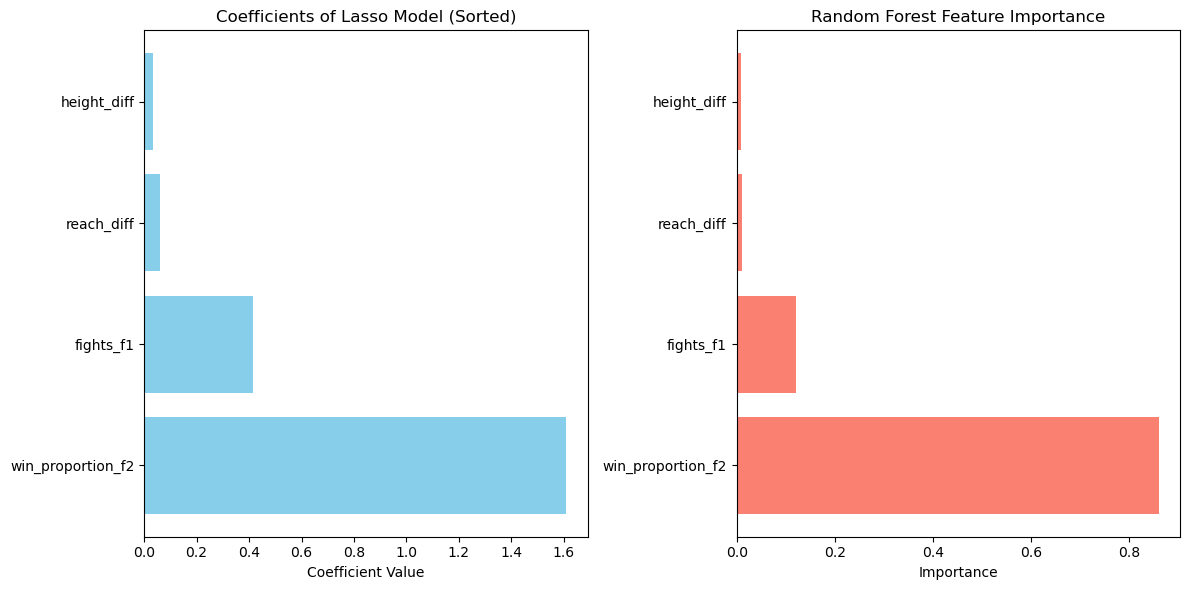

In [22]:
feature_names=X.columns
# Get feature importance for Logistic Regression
lasso_coefficients = best_models['Logistic Regression'].coef_[0]
lasso_feature_names = feature_names

# Filter coefficients and feature names where coefficient is greater than zero
selected_coefficients = [coef for coef, name in zip(lasso_coefficients, lasso_feature_names) if coef > 0]
selected_feature_names = [name for coef, name in zip(lasso_coefficients, lasso_feature_names) if coef > 0]

# Sort the coefficients and feature names based on coefficients
sorted_indices = np.argsort(selected_coefficients)[::-1]
sorted_coefficients = [selected_coefficients[i] for i in sorted_indices]
sorted_feature_names = [selected_feature_names[i] for i in sorted_indices]

# Get feature importance for Random Forest
rf_importance = best_models['Random Forest Classifier'].feature_importances_
sorted_indices_rf = np.argsort(rf_importance)[::-1]

#

# Plot the coefficients
# Plot feature importance
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(sorted_feature_names, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Coefficients of Lasso Model (Sorted)')

plt.subplot(1, 2, 2)
plt.barh([feature_names[i] for i in sorted_indices_rf], rf_importance[sorted_indices_rf], color='salmon')
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')

plt.tight_layout()
plt.show()